In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print(f"Examples:\n    Total: {total}\n    Positive: {pos} ({(100*pos/total):.2f}% of total)\n")

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [6]:
cleaned_df = raw_df.copy()

cleaned_df.pop('Time')

eps = 0.001
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [7]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print("Training labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

print("Training features shape:", train_features.shape)
print("Validation features shape:", val_features.shape)
print("Test features shape:", test_features.shape)

Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


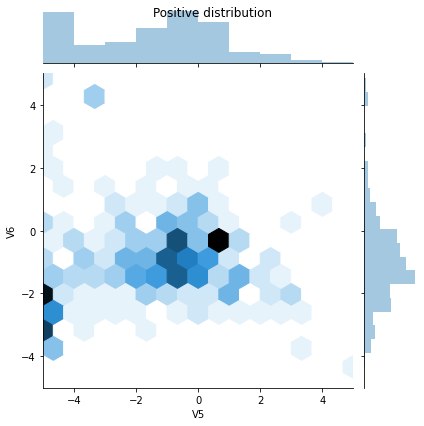

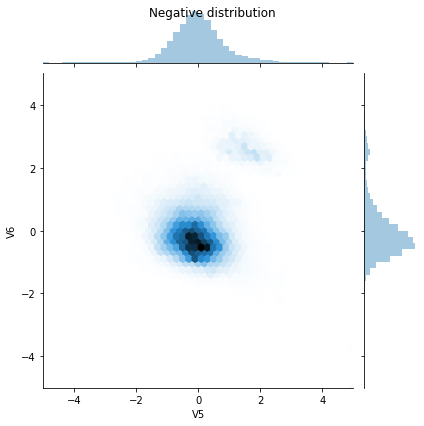

In [9]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),           
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),                          
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
  
  return model

In [11]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [12]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.predict(train_features[:10])

array([[0.5982441 ],
       [0.67689997],
       [0.60472786],
       [0.52767503],
       [0.5367036 ],
       [0.8940545 ],
       [0.74814826],
       [0.5609817 ],
       [0.37776557],
       [0.75869316]], dtype=float32)

In [14]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print(f"Loss: {results[0]:0.4f}")

Loss: 1.1223


In [15]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [16]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00036852],
       [0.00433485],
       [0.00088496],
       [0.00116283],
       [0.00105748],
       [0.0032178 ],
       [0.00356796],
       [0.00141484],
       [0.00105763],
       [0.00132504]], dtype=float32)

In [17]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print(f"Loss: {results[0]:0.4f}")

Loss: 0.0133


In [18]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [19]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [20]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [21]:
def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val '+label,
               linestyle="--")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.legend()

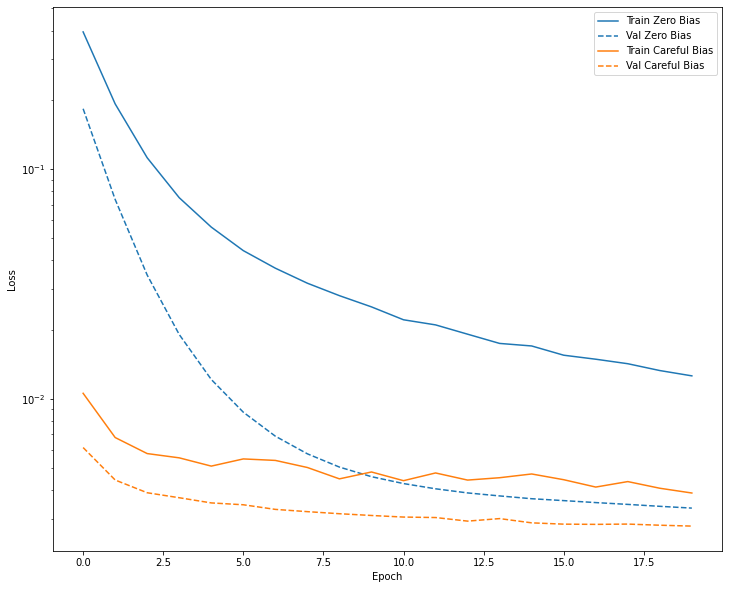

In [22]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [23]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
90/90 [==============================] - 1s 14ms/step - loss: 0.0109 - tp: 94.0000 - fp: 22.0000 - tn: 227434.0000 - fn: 295.0000 - accuracy: 0.9986 - precision: 0.8103 - recall: 0.2416 - auc: 0.7664 - val_loss: 0.0066 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 45493.0000 - val_fn: 73.0000 - val_accuracy: 0.9984 - val_precision: 0.6667 - val_recall: 0.0267 - val_auc: 0.9124
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0066 - tp: 123.0000 - fp: 20.0000 - tn: 181942.0000 - fn: 191.0000 - accuracy: 0.9988 - precision: 0.8601 - recall: 0.3917 - auc: 0.8749 - val_loss: 0.0044 - val_tp: 32.0000 - val_fp: 4.0000 - val_tn: 45490.0000 - val_fn: 43.0000 - val_accuracy: 0.9990 - val_precision: 0.8889 - val_recall: 0.4267 - val_auc: 0.9128
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.0061 - tp: 148.0000 - fp: 36.0000 - tn: 181926.0000 - fn: 166.0000 - accuracy: 0.9989 - precision: 0.8043 - recall: 0.4713 - auc: 0.8918 - val_l

In [24]:
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_", " ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label="Val")
    plt.xlabel("Epoch")
    plt.ylabel(name)
    if metric == "loss":
      plt.ylim([0, plt.ylim()[1]])
    elif metric == "auc":
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])
    
    plt.legend()

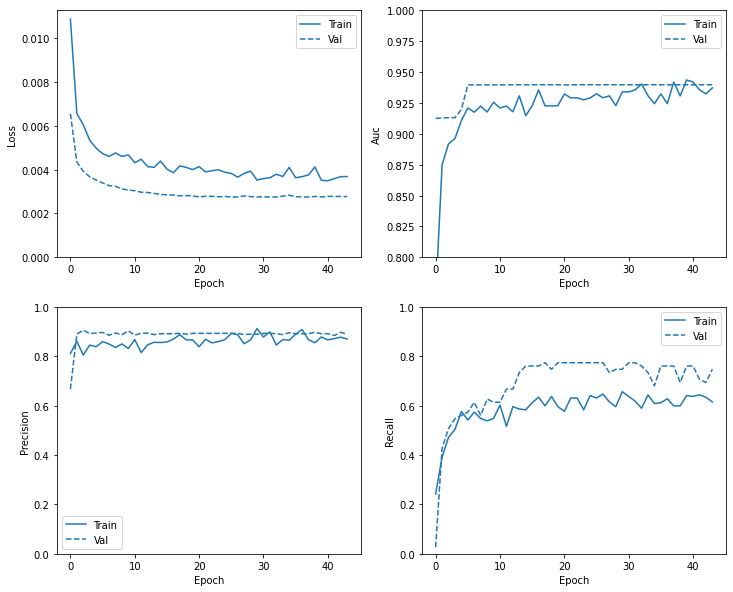

In [25]:
plot_metrics(baseline_history)

In [26]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [27]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title(f"Confusion matrix @{p:.2f}")
  plt.ylabel("Actual label")
  plt.xlabel("Predicted label")

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.0034019174054265022
tp :  79.0
fp :  10.0
tn :  56849.0
fn :  24.0
accuracy :  0.9994031190872192
precision :  0.8876404762268066
recall :  0.7669903039932251
auc :  0.9268598556518555

Legitimate Transactions Detected (True Negatives):  56849
Legitimate Transactions Incorrectly Detected (False Positives):  10
Fraudulent Transactions Missed (False Negatives):  24
Fraudulent Transactions Detected (True Positives):  79
Total Fraudulent Transactions:  103


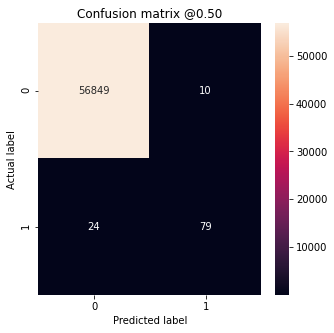

In [28]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(model.metrics_names, baseline_results):
  print(name, ": ", value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [29]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel("False positives [%]")
  plt.ylabel("True positives [%]")
  plt.xlim([-0.5, 20])
  plt.ylim([80, 100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

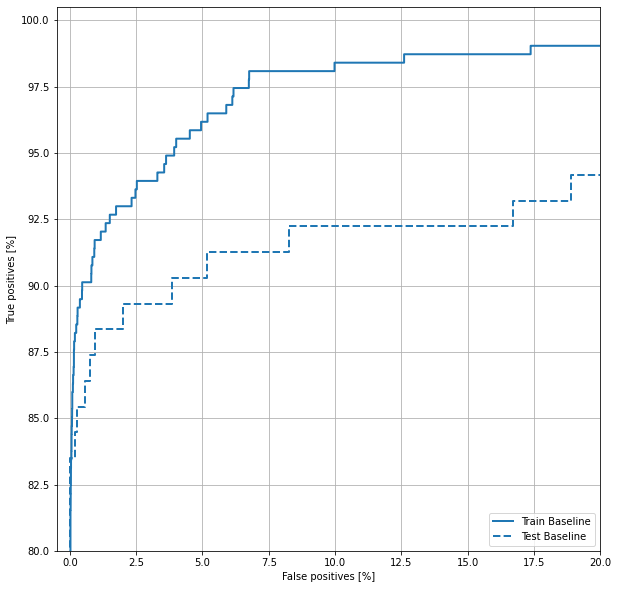

In [30]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle="--")
plt.legend(loc="lower right")

In [31]:
weight_for_0 = (1 / neg)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight class for 0: {weight_for_0:.2f}")
print(f"Weight class for 1: {weight_for_1:.2f}")

Weight class for 0: 0.50
Weight class for 1: 289.44


In [32]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 1s 14ms/step - loss: 2.4864 - tp: 122.0000 - fp: 54.0000 - tn: 238767.0000 - fn: 295.0000 - accuracy: 0.9985 - precision: 0.6932 - recall: 0.2926 - auc: 0.7737 - val_loss: 0.0059 - val_tp: 22.0000 - val_fp: 4.0000 - val_tn: 45490.0000 - val_fn: 53.0000 - val_accuracy: 0.9987 - val_precision: 0.8462 - val_recall: 0.2933 - val_auc: 0.9416
Epoch 2/100
90/90 [==============================] - 1s 7ms/step - loss: 1.0041 - tp: 160.0000 - fp: 176.0000 - tn: 181786.0000 - fn: 154.0000 - accuracy: 0.9982 - precision: 0.4762 - recall: 0.5096 - auc: 0.9044 - val_loss: 0.0059 - val_tp: 53.0000 - val_fp: 14.0000 - val_tn: 45480.0000 - val_fn: 22.0000 - val_accuracy: 0.9992 - val_precision: 0.7910 - val_recall: 0.7067 - val_auc: 0.9596
Epoch 3/100
90/90 [==============================] - 1s 7ms/step - loss: 0.7116 - tp: 203.0000 - fp: 408.0000 - tn: 181554.0000 - fn: 111.0000 - accuracy: 0.9972 - precision: 0.3322 - recall: 0.6465 - auc: 0.9278 - 

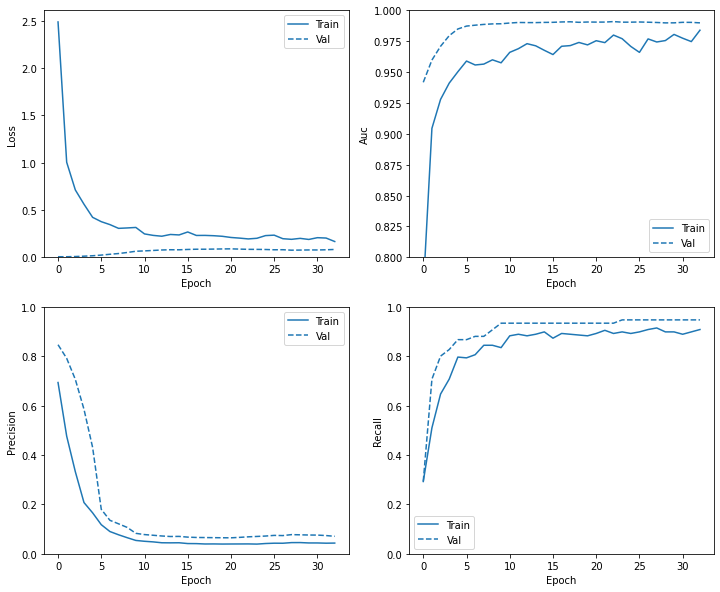

In [33]:
plot_metrics(weighted_history)

In [34]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.08737684041261673
tp :  92.0
fp :  1138.0
tn :  55721.0
fn :  11.0
accuracy :  0.9798286557197571
precision :  0.07479675114154816
recall :  0.893203854560852
auc :  0.9699102640151978

Legitimate Transactions Detected (True Negatives):  55721
Legitimate Transactions Incorrectly Detected (False Positives):  1138
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  92
Total Fraudulent Transactions:  103


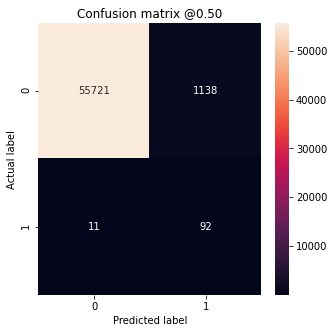

In [35]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

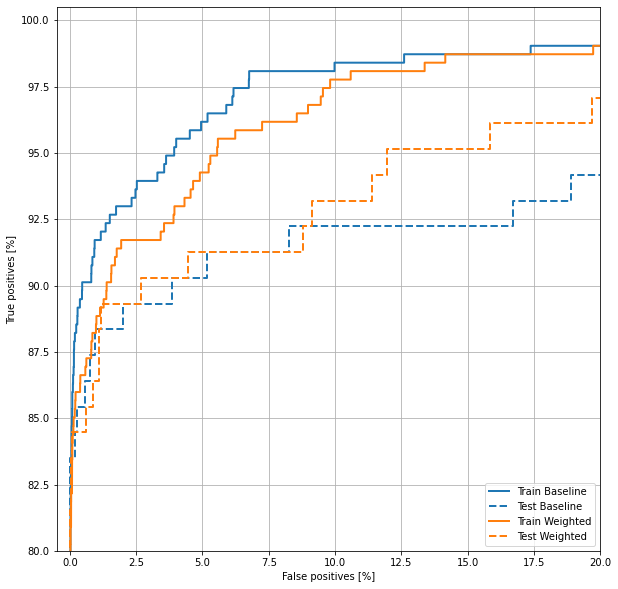

In [36]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [37]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [38]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181962, 29)

In [39]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363924, 29)

In [40]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [41]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-3.67580229  3.71325066 -5.          2.95320756 -4.41445219 -2.32896476
 -5.          4.35591059 -2.28934667 -5.          3.11998517 -5.
 -0.84362655 -5.          1.04595218 -5.         -5.         -3.08323811
  0.88362205  1.04661813  1.24576275 -0.8698624   0.31013762 -0.10441961
  0.72907963 -0.55482921  2.9493844   0.77964241  0.82163806]

Label:  1


In [42]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [43]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50439453125


In [44]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [45]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels))
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
278/278 [==============================] - 5s 19ms/step - loss: 0.3650 - tp: 240133.0000 - fp: 49512.0000 - tn: 292480.0000 - fn: 44181.0000 - accuracy: 0.8504 - precision: 0.8291 - recall: 0.8446 - auc: 0.9273 - val_loss: 0.1558 - val_tp: 70.0000 - val_fp: 1321.0000 - val_tn: 44173.0000 - val_fn: 5.0000 - val_accuracy: 0.9709 - val_precision: 0.0503 - val_recall: 0.9333 - val_auc: 0.9858
Epoch 2/100
278/278 [==============================] - 5s 17ms/step - loss: 0.1699 - tp: 258989.0000 - fp: 15434.0000 - tn: 269968.0000 - fn: 24953.0000 - accuracy: 0.9291 - precision: 0.9438 - recall: 0.9121 - auc: 0.9832 - val_loss: 0.0892 - val_tp: 70.0000 - val_fp: 968.0000 - val_tn: 44526.0000 - val_fn: 5.0000 - val_accuracy: 0.9786 - val_precision: 0.0674 - val_recall: 0.9333 - val_auc: 0.9858
Epoch 3/100
278/278 [==============================] - 5s 17ms/step - loss: 0.1331 - tp: 262221.0000 - fp: 10458.0000 - tn: 273915.0000 - fn: 22750.0000 - accuracy: 0.9417 - precision: 0.9616 -

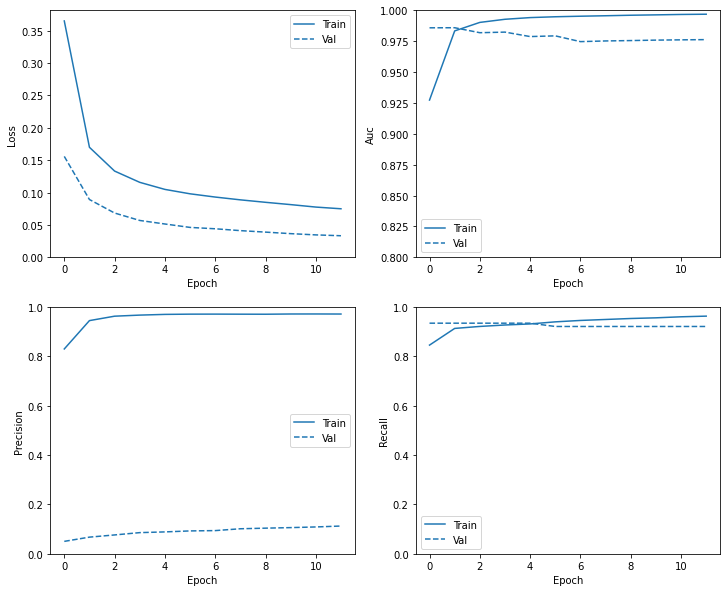

In [46]:
plot_metrics(resampled_history)

In [47]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

Epoch 1/1000
20/20 [==============================] - 1s 55ms/step - loss: 0.9748 - tp: 10860.0000 - fp: 6730.0000 - tn: 59172.0000 - fn: 9767.0000 - accuracy: 0.8093 - precision: 0.6174 - recall: 0.5265 - auc: 0.8432 - val_loss: 0.4962 - val_tp: 62.0000 - val_fp: 9895.0000 - val_tn: 35599.0000 - val_fn: 13.0000 - val_accuracy: 0.7826 - val_precision: 0.0062 - val_recall: 0.8267 - val_auc: 0.8859
Epoch 2/1000
20/20 [==============================] - 0s 23ms/step - loss: 0.6347 - tp: 14302.0000 - fp: 6289.0000 - tn: 14262.0000 - fn: 6107.0000 - accuracy: 0.6974 - precision: 0.6946 - recall: 0.7008 - auc: 0.7625 - val_loss: 0.4742 - val_tp: 69.0000 - val_fp: 8910.0000 - val_tn: 36584.0000 - val_fn: 6.0000 - val_accuracy: 0.8043 - val_precision: 0.0077 - val_recall: 0.9200 - val_auc: 0.9529
Epoch 3/1000
20/20 [==============================] - 0s 23ms/step - loss: 0.4747 - tp: 16393.0000 - fp: 5777.0000 - tn: 14803.0000 - fn: 3987.0000 - accuracy: 0.7616 - precision: 0.7394 - recall: 0.80

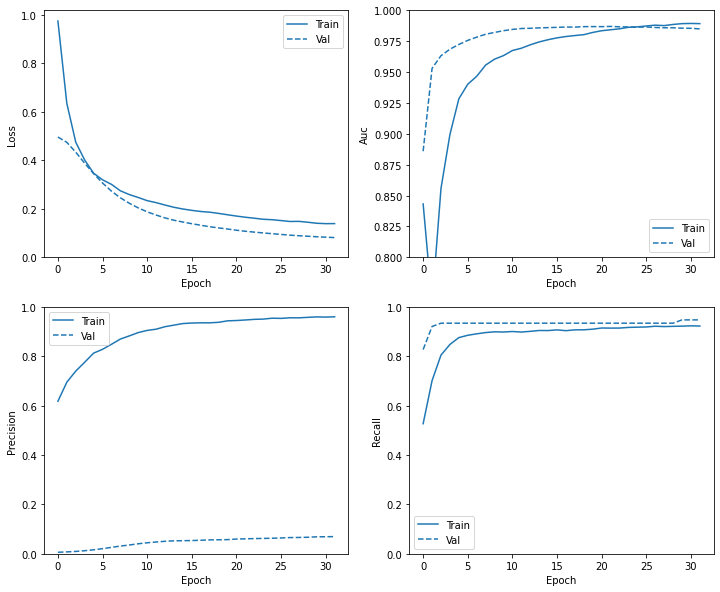

In [48]:
plot_metrics(resampled_history)

In [49]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.10889703035354614
tp :  93.0
fp :  1306.0
tn :  55553.0
fn :  10.0
accuracy :  0.9768968820571899
precision :  0.06647605448961258
recall :  0.9029126167297363
auc :  0.9573239088058472

Legitimate Transactions Detected (True Negatives):  55553
Legitimate Transactions Incorrectly Detected (False Positives):  1306
Fraudulent Transactions Missed (False Negatives):  10
Fraudulent Transactions Detected (True Positives):  93
Total Fraudulent Transactions:  103


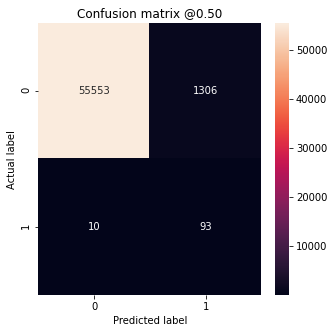

In [50]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

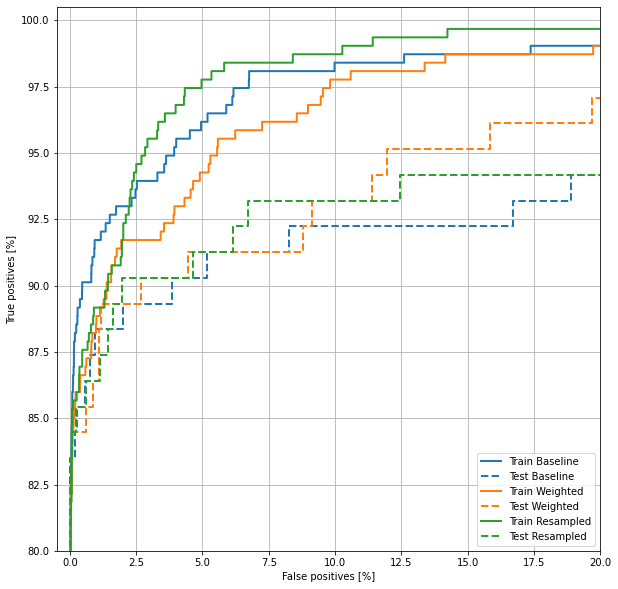

In [51]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')